# Custom Parameters :

In [1]:
#Assign these values as per your requirements.
global min_qubits,max_qubits,skip_qubits,max_circuits,num_shots,Noise_Inclusion

min_qubits=3 #min_qubits are incremented to 4 w.r.t algorithm "qubits should be of even number"
max_qubits=31
skip_qubits=1 #minimum Skip_qubits used is 2 (by default skip_qubits=2 when skip_qubits<2)
max_circuits=2
num_shots=1000
Noise_Inclusion = True
saveplots = True

Type_of_Simulator = "FAKEV2" #Inputs are "built_in" or "FAKE" or "FAKEV2"

#Change your Specification of Simulator in Declaring Backend Section
#By Default : built_in -> qasm_simulator and FAKE -> FakeSantiago() and FAKEV2 -> FakeJakartaV2()

# Imports:

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, execute
import time
import matplotlib.pyplot as plt
import resource
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,pauli_error, depolarizing_error, thermal_relaxation_error,reset_error)

# Benchmark Name
benchmark_name = "Hidden Shift"


# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 2
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

np.random.seed(0)

# Declaring Backend :

In [3]:
def get_QV(backend):
    import json

    # Assuming backend.conf_filename is the filename and backend.dirname is the directory path
    conf_filename = backend.dirname + "/" + backend.conf_filename
    
    # Open the JSON file
    with open(conf_filename, 'r') as file:
        # Load the JSON data
        data = json.load(file)
    
    # Extract the quantum_volume parameter
    QV = data.get('quantum_volume', None)
    return QV

In [4]:
if Type_of_Simulator == "built_in":
    platform = "qasm_simulator"   #By default using "Qasm Simulator"
    backend = Aer.get_backend(platform)
    QV_=None
    print(f"{platform} device is capable of running {backend.num_qubits}")
    print(f"backend version is {backend.backend_version}")
elif Type_of_Simulator == "FAKE":
    from qiskit.providers.fake_provider import FakeSantiago #make import as per your requirements
    basis_selector = 0
    backend = FakeSantiago()  #Use the corresponding method for declaring backend
    QV_ = get_QV(backend)
    platform = backend.properties().backend_name +"-"+ backend.properties().backend_version #Replace this string with the backend Provider's name as this is used for Plotting.
    max_qubits=backend.configuration().n_qubits
    
    print(f"{platform} device is capable of running {backend.configuration().n_qubits}")
    print(f"{platform} has QV={QV_}")
    if max_qubits > 30:
        print(f"Device is capable with max_qubits = {max_qubits}")
        max_qubit = 30
    print(f"Using fake backend {platform} with max_qubits {max_qubits}")

elif Type_of_Simulator == "FAKEV2":
    from qiskit.providers.fake_provider import FakeJakartaV2 #make import as per your requirements
    basis_selector = 0
    backend = FakeJakartaV2()  #Use the corresponding method for declaring backend
    QV_ = get_QV(backend)
    platform = backend.name +"-" +backend.backend_version #Replace this string with the backend Provider's name as this is used for Plotting.
    max_qubits=backend.num_qubits
    print(f"{platform} device is capable of running {backend.num_qubits}")
    print(f"{platform} has QV={QV_}")
    if max_qubits > 30:
        print(f"Device is capable with max_qubits = {max_qubits}")
        max_qubit = 30
    print(f"Using fake backend {platform} with max_qubits {max_qubits}")
else:
    print("Enter valid Simulator.....")

fake_jakarta-1.0.11 device is capable of running 7
fake_jakarta-1.0.11 has QV=16
Using fake backend fake_jakarta-1.0.11 with max_qubits 7


/tmp/ipykernel_36432/3852063070.py:25: DeprecationWarning: The class ``qiskit.providers.fake_provider.fake_backend.FakeBackendV2`` is deprecated as of qiskit 0.46.0. It will be removed in qiskit 1.0. All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. 
  backend = FakeJakartaV2()  #Use the corresponding method for declaring backend


# Algorithm :

In [5]:
# saved circuits for display
QC_ = None
Uf_ = None
Ug_ = None

# Circuit Definition

# Uf oracle where Uf|x> = f(x)|x>, f(x) = {-1,1}
def Uf_oracle(num_qubits, secret_int):
    # Initialize qubits qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name=f"Uf")

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.x(qr[i_qubit])

    for i_qubit in range(0,num_qubits-1,2):
        qc.cz(qr[i_qubit], qr[i_qubit+1])

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0'+str(num_qubits)+'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits-1-i_qubit]=='1':
            qc.x(qr[i_qubit])

    global UfC_ops
    UfC_ops = qc.count_ops()

    return qc

In [6]:
# Generate Ug oracle where Ug|x> = g(x)|x>, g(x) = f(x+s)
def Ug_oracle(num_qubits):
    # Initialize first n qubits
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr, name=f"Ug")

    for i_qubit in range(0,num_qubits-1,2):
        qc.cz(qr[i_qubit], qr[i_qubit+1])

    global UgC_ops
    UgC_ops = qc.count_ops()

    return qc

In [7]:
def HiddenShift (num_qubits, secret_int):
    
    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(num_qubits);
    qc = QuantumCircuit(qr, cr, name=f"hs-{num_qubits}-{secret_int}")
    
    # Start with Hadamard on all input qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])

    qc.barrier()

    # Generate Uf oracle where Uf|x> = f(x)|x>, f(x) = {-1,1}
    Uf = Uf_oracle(num_qubits, secret_int)
    qc.append(Uf,qr)

    qc.barrier()
    
    # Again do Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])

    qc.barrier()

    # Generate Ug oracle where Ug|x> = g(x)|x>, g(x) = f(x+s)
    Ug = Ug_oracle(num_qubits)
    qc.append(Ug,qr)

    qc.barrier()

    # End with Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(qr[i_qubit])
        
    qc.barrier()
    
    # measure all qubits
    qc.measure(qr, cr)

    # save smaller circuit example for display
    global QC_, Uf_, Ug_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf
    if Ug_ == None or num_qubits <= 6:
        if num_qubits < 9: Ug_ = Ug
        
    # return a handle on the circuit
    return qc

# Noise Parameters :

In [8]:
# Create an empty noise model
noise_parameters = NoiseModel()

if Type_of_Simulator == "built_in":
    # Add depolarizing error to all single qubit gates with error rate 0.05% and to all two qubit gates with error rate 0.5%
    depol_one_qb_error = 0.05
    depol_two_qb_error = 0.005
    noise_parameters.add_all_qubit_quantum_error(depolarizing_error(depol_one_qb_error, 1), ['rx', 'ry', 'rz'])
    noise_parameters.add_all_qubit_quantum_error(depolarizing_error(depol_two_qb_error, 2), ['cx'])
    
    # Add amplitude damping error to all single qubit gates with error rate 0.0% and to all two qubit gates with error rate 0.0%
    amp_damp_one_qb_error = 0.0
    amp_damp_two_qb_error = 0.0
    noise_parameters.add_all_qubit_quantum_error(depolarizing_error(amp_damp_one_qb_error, 1), ['rx', 'ry', 'rz'])
    noise_parameters.add_all_qubit_quantum_error(depolarizing_error(amp_damp_two_qb_error, 2), ['cx'])
    
    # Add reset noise to all single qubit resets
    reset_to_zero_error = 0.005
    reset_to_one_error = 0.005
    noise_parameters.add_all_qubit_quantum_error(reset_error(reset_to_zero_error, reset_to_one_error),["reset"])
    
    # Add readout error
    p0given1_error = 0.000
    p1given0_error = 0.000
    error_meas = ReadoutError([[1 - p1given0_error, p1given0_error], [p0given1_error, 1 - p0given1_error]])
    noise_parameters.add_all_qubit_readout_error(error_meas)
    
    #print(noise_parameters)

elif Type_of_Simulator == "FAKE"or"FAKEV2":
    noise_parameters = NoiseModel.from_backend(backend)
    print(noise_parameters)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'x', 'reset', 'id', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (3, 5)), ('cx', (5, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,))]


# Fidelity Calculations :

In [9]:
### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    num_measured_qubits = len(list(correct_dist.keys())[0])
    #print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity

def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist

# Functions of Volumetric Plots :

In [10]:

from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from matplotlib.patches import Circle

############### Color Map functions
 
# Create a selection of colormaps from which to choose; default to custom_spectral
cmap_spectral = plt.get_cmap('Spectral')
cmap_greys = plt.get_cmap('Greys')
cmap_blues = plt.get_cmap('Blues')
cmap_custom_spectral = None

# the default colormap is the spectral map
cmap = cmap_spectral
cmap_orig = cmap_spectral

# current cmap normalization function (default None)
cmap_norm = None

default_fade_low_fidelity_level = 0.16
default_fade_rate = 0.7


# Specify a normalization function here (default None)
def set_custom_cmap_norm(vmin, vmax):

    global cmap_norm
    
    if vmin == vmax or (vmin == 0.0 and vmax == 1.0):
        print("... setting cmap norm to None")
        cmap_norm = None
    else:
        print(f"... setting cmap norm to [{vmin}, {vmax}]")
        cmap_norm = Normalize(vmin=vmin, vmax=vmax)
    
# Remake the custom spectral colormap with user settings
def set_custom_cmap_style(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):
            
    #print("... set custom map style")
    global cmap, cmap_custom_spectral, cmap_orig
    cmap_custom_spectral = create_custom_spectral_cmap(
                fade_low_fidelity_level=fade_low_fidelity_level, fade_rate=fade_rate)
    cmap = cmap_custom_spectral
    cmap_orig = cmap_custom_spectral


# Create the custom spectral colormap from the base spectral
def create_custom_spectral_cmap(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):

    # determine the breakpoint from the fade level
    num_colors = 100
    breakpoint = round(fade_low_fidelity_level * num_colors)
    
    # get color list for spectral map
    spectral_colors = [cmap_spectral(v/num_colors) for v in range(num_colors)]

    #print(fade_rate)
    
    # create a list of colors to replace those below the breakpoint
    # and fill with "faded" color entries (in reverse)
    low_colors = [0] * breakpoint
    #for i in reversed(range(breakpoint)):
    for i in range(breakpoint):
    
        # x is index of low colors, normalized 0 -> 1
        x = i / breakpoint
    
        # get color at this index
        bc = spectral_colors[i]
        r0 = bc[0]
        g0 = bc[1]
        b0 = bc[2]
        z0 = bc[3]
        
        r_delta = 0.92 - r0
        
        #print(f"{x} {bc} {r_delta}")
         
        # compute saturation and greyness ratio
        sat_ratio = 1 - x
        
        #grey_ratio = 1 - x
        '''  attempt at a reflective gradient   
        if i >= breakpoint/2:
            xf = 2*(x - 0.5)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (yf + 0.5)
        else:
            xf = 2*(0.5 - x)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (0.5 - yf)
        '''   
        grey_ratio = 1 - math.pow(x, 1/fade_rate)
        
        #print(f"  {xf} {yf} ")
        #print(f"  {sat_ratio} {grey_ratio}")

        r = r0 + r_delta * sat_ratio
        
        g_delta = r - g0
        b_delta = r - b0
        g = g0 + g_delta * grey_ratio
        b = b0 + b_delta * grey_ratio 
            
        #print(f"{r} {g} {b}\n")    
        low_colors[i] = (r,g,b,z0)
        
    #print(low_colors)

    # combine the faded low colors with the regular spectral cmap to make a custom version
    cmap_custom_spectral = ListedColormap(low_colors + spectral_colors[breakpoint:])

    #spectral_colors = [cmap_custom_spectral(v/10) for v in range(10)]
    #for i in range(10): print(spectral_colors[i])
    #print("")
    
    return cmap_custom_spectral

# Make the custom spectral color map the default on module init
set_custom_cmap_style()

# Arrange the stored annotations optimally and add to plot 
def anno_volumetric_data(ax, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True):
    
    # sort all arrays by the x point of the text (anno_offs)
    global x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos
    all_annos = sorted(zip(x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos))
    x_anno_offs = [a for a,b,c,d,e in all_annos]
    y_anno_offs = [b for a,b,c,d,e in all_annos]
    anno_labels = [c for a,b,c,d,e in all_annos]
    x_annos = [d for a,b,c,d,e in all_annos]
    y_annos = [e for a,b,c,d,e in all_annos]
    
    #print(f"{x_anno_offs}")
    #print(f"{y_anno_offs}")
    #print(f"{anno_labels}")
    
    for i in range(len(anno_labels)):
        x_anno = x_annos[i]
        y_anno = y_annos[i]
        x_anno_off = x_anno_offs[i]
        y_anno_off = y_anno_offs[i]
        label = anno_labels[i]
        
        if i > 0:
            x_delta = abs(x_anno_off - x_anno_offs[i - 1])
            y_delta = abs(y_anno_off - y_anno_offs[i - 1])
            
            if y_delta < 0.7 and x_delta < 2:
                y_anno_off = y_anno_offs[i] = y_anno_offs[i - 1] - 0.6
                #x_anno_off = x_anno_offs[i] = x_anno_offs[i - 1] + 0.1
                    
        ax.annotate(label,
            xy=(x_anno+0.0, y_anno+0.1),
            arrowprops=dict(facecolor='black', shrink=0.0,
                width=0.5, headwidth=4, headlength=5, edgecolor=(0.8,0.8,0.8)),
            xytext=(x_anno_off + labelpos[0], y_anno_off + labelpos[1]),
            rotation=labelrot,
            horizontalalignment='left', verticalalignment='baseline',
            color=(0.2,0.2,0.2),
            clip_on=True)
    if saveplots == True:
        plt.savefig("VolumetricPlotSample.jpg")

# Plot one group of data for volumetric presentation    
def plot_volumetric_data(ax, w_data, d_data, f_data, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True, w_max=18, do_label=False, do_border=True,
        x_size=1.0, y_size=1.0, zorder=1, offset_flag=False,
        max_depth=0, suppress_low_fidelity=False):

    # since data may come back out of order, save point at max y for annotation
    i_anno = 0
    x_anno = 0 
    y_anno = 0
    
    # plot data rectangles
    low_fidelity_count = True
    
    last_y = -1
    k = 0

    # determine y-axis dimension for one pixel to use for offset of bars that start at 0
    (_, dy) = get_pixel_dims(ax)
    
    # do this loop in reverse to handle the case where earlier cells are overlapped by later cells
    for i in reversed(range(len(d_data))):
        x = depth_index(d_data[i], depth_base)
        y = float(w_data[i])
        f = f_data[i]
        
        # each time we star a new row, reset the offset counter
        # DEVNOTE: this is highly specialized for the QA area plots, where there are 8 bars
        # that represent time starting from 0 secs.  We offset by one pixel each and center the group
        if y != last_y:
            last_y = y;
            k = 3              # hardcoded for 8 cells, offset by 3
        
        #print(f"{i = } {x = } {y = }")
        
        if max_depth > 0 and d_data[i] > max_depth:
            #print(f"... excessive depth (2), skipped; w={y} d={d_data[i]}")
            break;
            
        # reject cells with low fidelity
        if suppress_low_fidelity and f < suppress_low_fidelity_level:
            if low_fidelity_count: break
            else: low_fidelity_count = True
        
        # the only time this is False is when doing merged gradation plots
        if do_border == True:
        
            # this case is for an array of x_sizes, i.e. each box has different width
            if isinstance(x_size, list):
                
                # draw each of the cells, with no offset
                if not offset_flag:
                    ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size[i], y_size=y_size, zorder=zorder))
                    
                # use an offset for y value, AND account for x and width to draw starting at 0
                else:
                    ax.add_patch(box_at((x/2 + x_size[i]/4), y + k*dy, f, type=type, fill=fill, x_size=x+ x_size[i]/2, y_size=y_size, zorder=zorder))
                
            # this case is for only a single cell
            else:
                ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size, y_size=y_size))

        # save the annotation point with the largest y value
        if y >= y_anno:
            x_anno = x
            y_anno = y
            i_anno = i
        
        # move the next bar down (if using offset)
        k -= 1
    
    # if no data rectangles plotted, no need for a label
    if x_anno == 0 or y_anno == 0:
        return
        
    x_annos.append(x_anno)
    y_annos.append(y_anno)
    
    anno_dist = math.sqrt( (y_anno - 1)**2 + (x_anno - 1)**2 )
    
    # adjust radius of annotation circle based on maximum width of apps
    anno_max = 10
    if w_max > 10:
        anno_max = 14
    if w_max > 14:
        anno_max = 18
        
    scale = anno_max / anno_dist

    # offset of text from end of arrow
    if scale > 1:
        x_anno_off = scale * x_anno - x_anno - 0.5
        y_anno_off = scale * y_anno - y_anno
    else:
        x_anno_off = 0.7
        y_anno_off = 0.5
        
    x_anno_off += x_anno
    y_anno_off += y_anno
    
    # print(f"... {xx} {yy} {anno_dist}")
    x_anno_offs.append(x_anno_off)
    y_anno_offs.append(y_anno_off)
    
    anno_labels.append(label)
    
    if do_label:
        ax.annotate(label, xy=(x_anno+labelpos[0], y_anno+labelpos[1]), rotation=labelrot,
            horizontalalignment='left', verticalalignment='bottom', color=(0.2,0.2,0.2))

x_annos = []
y_annos = []
x_anno_offs = []
y_anno_offs = []
anno_labels = []

# init arrays to hold annotation points for label spreading
def vplot_anno_init ():

    global x_annos, y_annos, x_anno_offs, y_anno_offs, anno_labels
    
    x_annos = []
    y_annos = []
    x_anno_offs = []
    y_anno_offs = []
    anno_labels = []

# Number of ticks on volumetric depth axis
max_depth_log = 22

# average transpile factor between base QV depth and our depth based on results from QV notebook
QV_transpile_factor = 12.7 

# format a number using K,M,B,T for large numbers, optionally rounding to 'digits' decimal places if num > 1
# (sign handling may be incorrect)
def format_number(num, digits=0):
    if isinstance(num, str): num = float(num)
    num = float('{:.3g}'.format(abs(num)))
    sign = ''
    metric = {'T': 1000000000000, 'B': 1000000000, 'M': 1000000, 'K': 1000, '': 1}
    for index in metric:
        num_check = num / metric[index]
        if num_check >= 1:
            num = round(num_check, digits)
            sign = index
            break
    numstr = f"{str(num)}"
    if '.' in numstr:
        numstr = numstr.rstrip('0').rstrip('.')
    return f"{numstr}{sign}"

# Return the color associated with the spcific value, using color map norm
def get_color(value):
    
    # if there is a normalize function installed, scale the data
    if cmap_norm:
        value = float(cmap_norm(value))
        
    if cmap == cmap_spectral:
        value = 0.05 + value*0.9
    elif cmap == cmap_blues:
        value = 0.00 + value*1.0
    else:
        value = 0.0 + value*0.95
        
    return cmap(value)

# Return the x and y equivalent to a single pixel for the given plot axis
def get_pixel_dims(ax):

    # transform 0 -> 1 to pixel dimensions
    pixdims = ax.transData.transform([(0,1),(1,0)])-ax.transData.transform((0,0))
    xpix = pixdims[1][0]
    ypix = pixdims[0][1]
    
    #determine x- and y-axis dimension for one pixel 
    dx = (1 / xpix)
    dy = (1 / ypix)
    
    return (dx, dy)

############### Helper functions
 
# return the base index for a circuit depth value
# take the log in the depth base, and add 1
def depth_index(d, depth_base):
    if depth_base <= 1:
        return d
    if d == 0:
        return 0
    return math.log(d, depth_base) + 1

# draw a box at x,y with various attributes   
def box_at(x, y, value, type=1, fill=True, x_size=1.0, y_size=1.0, alpha=1.0, zorder=1):
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Rectangle((x - (x_size/2), y - (y_size/2)), x_size, y_size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5*y_size,
             zorder=zorder)

# draw a circle at x,y with various attributes 
def circle_at(x, y, value, type=1, fill=True):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Circle((x, y), size/2,
             alpha = 0.7,                       # DEVNOTE: changed to 0.7 from 0.5, to handle only one cell
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5)
             
def box4_at(x, y, value, type=1, fill=True, alpha=1.0):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.3,0.3,0.3)
    ec = fc
    
    return Rectangle((x - size/8, y - size/2), size/4, size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.1)

# Draw a Quantum Volume rectangle with specified width and depth, and grey-scale value 
def qv_box_at(x, y, qv_width, qv_depth, value, depth_base):
    #print(f"{qv_width} {qv_depth} {depth_index(qv_depth, depth_base)}")
    return Rectangle((x - 0.5, y - 0.5), depth_index(qv_depth, depth_base), qv_width,
             edgecolor = (value,value,value),
             facecolor = (value,value,value),
             fill=True,
             lw=1)

def bkg_box_at(x, y, value=0.9):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (value,value,value),
             fill=True,
             lw=0.5)
             
def bkg_empty_box_at(x, y):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (1.0,1.0,1.0),
             fill=True,
             lw=0.5)

# Plot the background for the volumetric analysis    
def plot_volumetric_background(max_qubits=11, QV=32, depth_base=2, suptitle=None, avail_qubits=0, colorbar_label="Avg Result Fidelity"):

    if suptitle == None:
        suptitle = f"Volumetric Positioning\nCircuit Dimensions and Fidelity Overlaid on Quantum Volume = {QV}"

    QV0 = QV
    qv_estimate = False
    est_str = ""
    if QV == 0:                 # QV = 0 indicates "do not draw QV background or label"
        QV = 2048
        
    elif QV < 0:                # QV < 0 indicates "add est. to label"
        QV = -QV
        qv_estimate = True
        est_str = " (est.)"
        
    if avail_qubits > 0 and max_qubits > avail_qubits:
        max_qubits = avail_qubits
        
    max_width = 13
    if max_qubits > 11: max_width = 18
    if max_qubits > 14: max_width = 20
    if max_qubits > 16: max_width = 24
    if max_qubits > 24: max_width = 33
    #print(f"... {avail_qubits} {max_qubits} {max_width}")
    
    plot_width = 6.8
    plot_height = 0.5 + plot_width * (max_width / max_depth_log)
    #print(f"... {plot_width} {plot_height}")
    
    # define matplotlib figure and axis; use constrained layout to fit colorbar to right
    fig, ax = plt.subplots(figsize=(plot_width, plot_height), constrained_layout=True)

    plt.suptitle(suptitle)

    plt.xlim(0, max_depth_log)
    plt.ylim(0, max_width)

    # circuit depth axis (x axis)
    xbasis = [x for x in range(1,max_depth_log)]
    xround = [depth_base**(x-1) for x in xbasis]
    xlabels = [format_number(x) for x in xround]
    ax.set_xlabel('Circuit Depth')
    ax.set_xticks(xbasis)  
    plt.xticks(xbasis, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor")
    
    # other label options
    #plt.xticks(xbasis, xlabels, color='black', rotation=-60, ha='left')
    #plt.xticks(xbasis, xlabels, color='black', rotation=-45, ha='left', va='center', rotation_mode="anchor")

    # circuit width axis (y axis)
    ybasis = [y for y in range(1,max_width)]
    yround = [1,2,3,4,5,6,7,8,10,12,15]     # not used now
    ylabels = [str(y) for y in yround]      # not used now 
    #ax.set_ylabel('Circuit Width (Number of Qubits)')
    ax.set_ylabel('Circuit Width')
    ax.set_yticks(ybasis)

    #create simple line plot (not used right now)
    #ax.plot([0, 10],[0, 10])
    
    log2QV = math.log2(QV)
    QV_width = log2QV
    QV_depth = log2QV * QV_transpile_factor
    
    # show a quantum volume rectangle of QV = 64 e.g. (6 x 6)
    if QV0 != 0:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.87, depth_base))
    else:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.91, depth_base))
    
    # the untranspiled version is commented out - we do not show this by default
    # also show a quantum volume rectangle un-transpiled
    # ax.add_patch(qv_box_at(1, 1, QV_width, QV_width, 0.80, depth_base))

    # show 2D array of volumetric cells based on this QV_transpiled
    # DEVNOTE: we use +1 only to make the visuals work; s/b without
    # Also, the second arg of the min( below seems incorrect, needs correction
    maxprod = (QV_width + 1) * (QV_depth + 1)
    for w in range(1, min(max_width, round(QV) + 1)):
        
        # don't show VB squares if width greater than known available qubits
        if avail_qubits != 0 and w > avail_qubits:
            continue
        
        i_success = 0
        for d in xround:
        
            # polarization factor for low circuit widths
            maxtest = maxprod / ( 1 - 1 / (2**w) )
            
            # if circuit would fail here, don't draw box
            if d > maxtest: continue
            if w * d > maxtest: continue
            
            # guess for how to capture how hardware decays with width, not entirely correct

            # # reduce maxtext by a factor of number of qubits > QV_width
            # # just an approximation to account for qubit distances
            # if w > QV_width:
            #     over = w - QV_width 
            #     maxtest = maxtest / (1 + (over/QV_width))

            # draw a box at this width and depth
            id = depth_index(d, depth_base) 
            
            # show vb rectangles; if not showing QV, make all hollow (or less dark)
            if QV0 == 0:
                #ax.add_patch(bkg_empty_box_at(id, w))
                ax.add_patch(bkg_box_at(id, w, 0.95))
            
            else:
                ax.add_patch(bkg_box_at(id, w, 0.9))
            
            # save index of last successful depth
            i_success += 1
        
        # plot empty rectangle after others       
        d = xround[i_success]
        id = depth_index(d, depth_base) 
        ax.add_patch(bkg_empty_box_at(id, w))
        
    
    # Add annotation showing quantum volume
    if QV0 != 0:
        t = ax.text(max_depth_log - 2.0, 1.5, f"QV{est_str}={QV}", size=12,
                horizontalalignment='right', verticalalignment='center', color=(0.2,0.2,0.2),
                bbox=dict(boxstyle="square,pad=0.3", fc=(.9,.9,.9), ec="grey", lw=1))
                
    # add colorbar to right of plot
    plt.colorbar(cm.ScalarMappable(cmap=cmap), cax=None, ax=ax,
            shrink=0.6, label=colorbar_label, panchor=(0.0, 0.7))
            
    return ax

# Benchmarking Essentials and Fidelity Plots :

In [11]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

In [12]:
def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend) 
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth,qc

In [13]:
def plot_fidelity_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())

    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    return avg_fidelity_means,avg_Hf_fidelity_means

In [14]:
def update_counts(gates,custom_gates):
    operations = {}
    for key, value in gates.items():
        operations[key] = value

    for key, value in custom_gates.items():
        if key in operations:
            operations[key] += value
        else:
            operations[key] = value
            
    return operations


def get_gate_counts(qc,custom_gate_defs):
    gates = dict(qc.count_ops())
    result = gates.copy()
    
    # Iterate over the gate counts in the quantum circuit
    for gate, count in gates.items():
        if gate in custom_gate_defs:
            custom_gate_ops = custom_gate_defs[gate]
            # Multiply custom gate operations by the count of the custom gate in the circuit
            for _ in range(count):
                result = update_counts(result, custom_gate_ops)
            # Remove the custom gate entry as we have expanded it
            del result[gate]
    
    return result

# Analyzer Function:

In [15]:
def analyzer(num_qubits,s_int):
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(s_int, f"0{num_qubits}b")
            
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}
    #print("correct_dist=",correct_dist)
    return correct_dist

# RUN Function :

In [16]:
def run (min_qubits=min_qubits, max_qubits=max_qubits, skip_qubits=skip_qubits, 
         max_circuits=max_circuits, num_shots=num_shots):

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}
    numckts = []
    algorithmic_1Q_gate_counts = []
    algorithmic_2Q_gate_counts = []
    transpiled_1Q_gate_counts = []
    transpiled_2Q_gate_counts = []
    
    print(f"{benchmark_name} Benchmark Program - {platform}")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    skip_qubits = max(2, skip_qubits)
    

    global max_ckts
    max_ckts = max_circuits

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits

    print(f"min, max qubits = {min_qubits} {max_qubits}")

    # Execute Benchmark Program N times for multiple circuit sizes
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)
        numckts.append(num_circuits)
        
        print(f"Executing [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
            
        for s_int in s_range:
            print("*********************************************")
            print(f"qc of {num_qubits} qubits for integer {s_int}")

            #creation of Quantum Circuit.
            ts = time.time()
            qc = HiddenShift(num_qubits, s_int)
               
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            #print(qc)
            print(f"creation time = {creation_time*1000} ms")
            
            # Calculate gate count for the algorithmic circuit (excluding barriers and measurements)
            custom_gate_defs = {'Ug': UgC_ops,'Uf': UfC_ops}# Add Custom gate dictionaries
            
            operations = get_gate_counts(qc,custom_gate_defs)
            
            n1q = 0; n2q = 0
            if operations != None:
                for key, value in operations.items():
                    if key == "measure": continue
                    if key == "barrier": continue
                    if key.startswith("c") or key.startswith("mc"):
                        n2q += value
                    else:
                        n1q += value
                        
            algorithmic_1Q_gate_counts.append(n1q)
            algorithmic_2Q_gate_counts.append(n2q)
            
            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            qc=qc.decompose()
            #print(qc)
            
            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)
            
            # Calculate transpiled circuit depth
            transpiled_depth,qc = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            #print(qc)
            
            print(f"Algorithmic Depth = {depth} and Normalized Depth = {transpiled_depth}")
            
            # Calculate gate count for the transpiled circuit (excluding barriers and measurements)
            tr_ops = qc.count_ops()
            #print("tr_ops = ",tr_ops)
            tr_n1q = 0; tr_n2q = 0
            if tr_ops != None:
                for key, value in tr_ops.items():
                    if key == "measure": continue
                    if key == "barrier": continue
                    if key.startswith("c"): tr_n2q += value
                    else: tr_n1q += value
                        
            transpiled_1Q_gate_counts.append(tr_n1q)
            transpiled_2Q_gate_counts.append(tr_n2q)
            
            print(f"Algorithmic 1Q gates = {n1q} ,Algorithmic 2Q gates = {n2q}")
            print(f"Normalized 1Q gates = {tr_n1q} ,Normalized 2Q gates = {tr_n2q}")
            
            
            #execution
            if Type_of_Simulator == "built_in":
                #To check if Noise is required
                if Noise_Inclusion == True:
                    noise_model = noise_parameters
                else:
                    noise_model = None
                ts = time.time()
                job = execute(qc, backend, shots=num_shots, noise_model=noise_model)
            elif Type_of_Simulator == "FAKE" or Type_of_Simulator == "FAKEV2" :
                ts = time.time()
                job =  backend.run(qc,shots=num_shots, noise_model=noise_parameters) 
                
            #retrieving the result 
            result = job.result()
            #print(result)
            
            #calculating elapsed time
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)
            
            
            # Calculate quantum processing time 
            quantum_time = result.time_taken
            quantum_times.append(quantum_time)

            print(f"Elapsed time = {elapsed_time*1000} ms and Quantum Time = {quantum_time*1000} ms")
            
            #counts in result object 
            counts = result.get_counts()
            #print("Counts = ",counts)

            #Correct distribution to compare with counts
            correct_dist = analyzer(num_qubits,s_int)
            
            #fidelity calculation comparision of counts and correct_dist 
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])

            print("*********************************************")
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else " ... too large!")
    print("\nQuantum Oracle 'Ug' ="); print(Ug_ if Ug_ != None else " ... too large!")
    
    return (creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, 
            fidelity_data, Hf_fidelity_data, numckts , algorithmic_1Q_gate_counts, algorithmic_2Q_gate_counts,
    transpiled_1Q_gate_counts, transpiled_2Q_gate_counts)

# Triggering RUN function :

Hidden Shift Benchmark Program - fake_jakarta-1.0.11
min, max qubits = 4 7
Executing [2] circuits with num_qubits = 4
*********************************************
qc of 4 qubits for integer 1
creation time = 2.389669418334961 ms
Algorithmic Depth = 8 and Normalized Depth = 24
Algorithmic 1Q gates = 14 ,Algorithmic 2Q gates = 4
Normalized 1Q gates = 62 ,Normalized 2Q gates = 4
Elapsed time = 211.05146408081055 ms and Quantum Time = 101.98283195495605 ms
*********************************************
*********************************************
qc of 4 qubits for integer 6
creation time = 0.9865760803222656 ms
Algorithmic Depth = 8 and Normalized Depth = 24
Algorithmic 1Q gates = 16 ,Algorithmic 2Q gates = 4
Normalized 1Q gates = 62 ,Normalized 2Q gates = 4
Elapsed time = 45.84026336669922 ms and Quantum Time = 45.5632209777832 ms
*********************************************
Executing [2] circuits with num_qubits = 6
*********************************************
qc of 6 qubits for inte

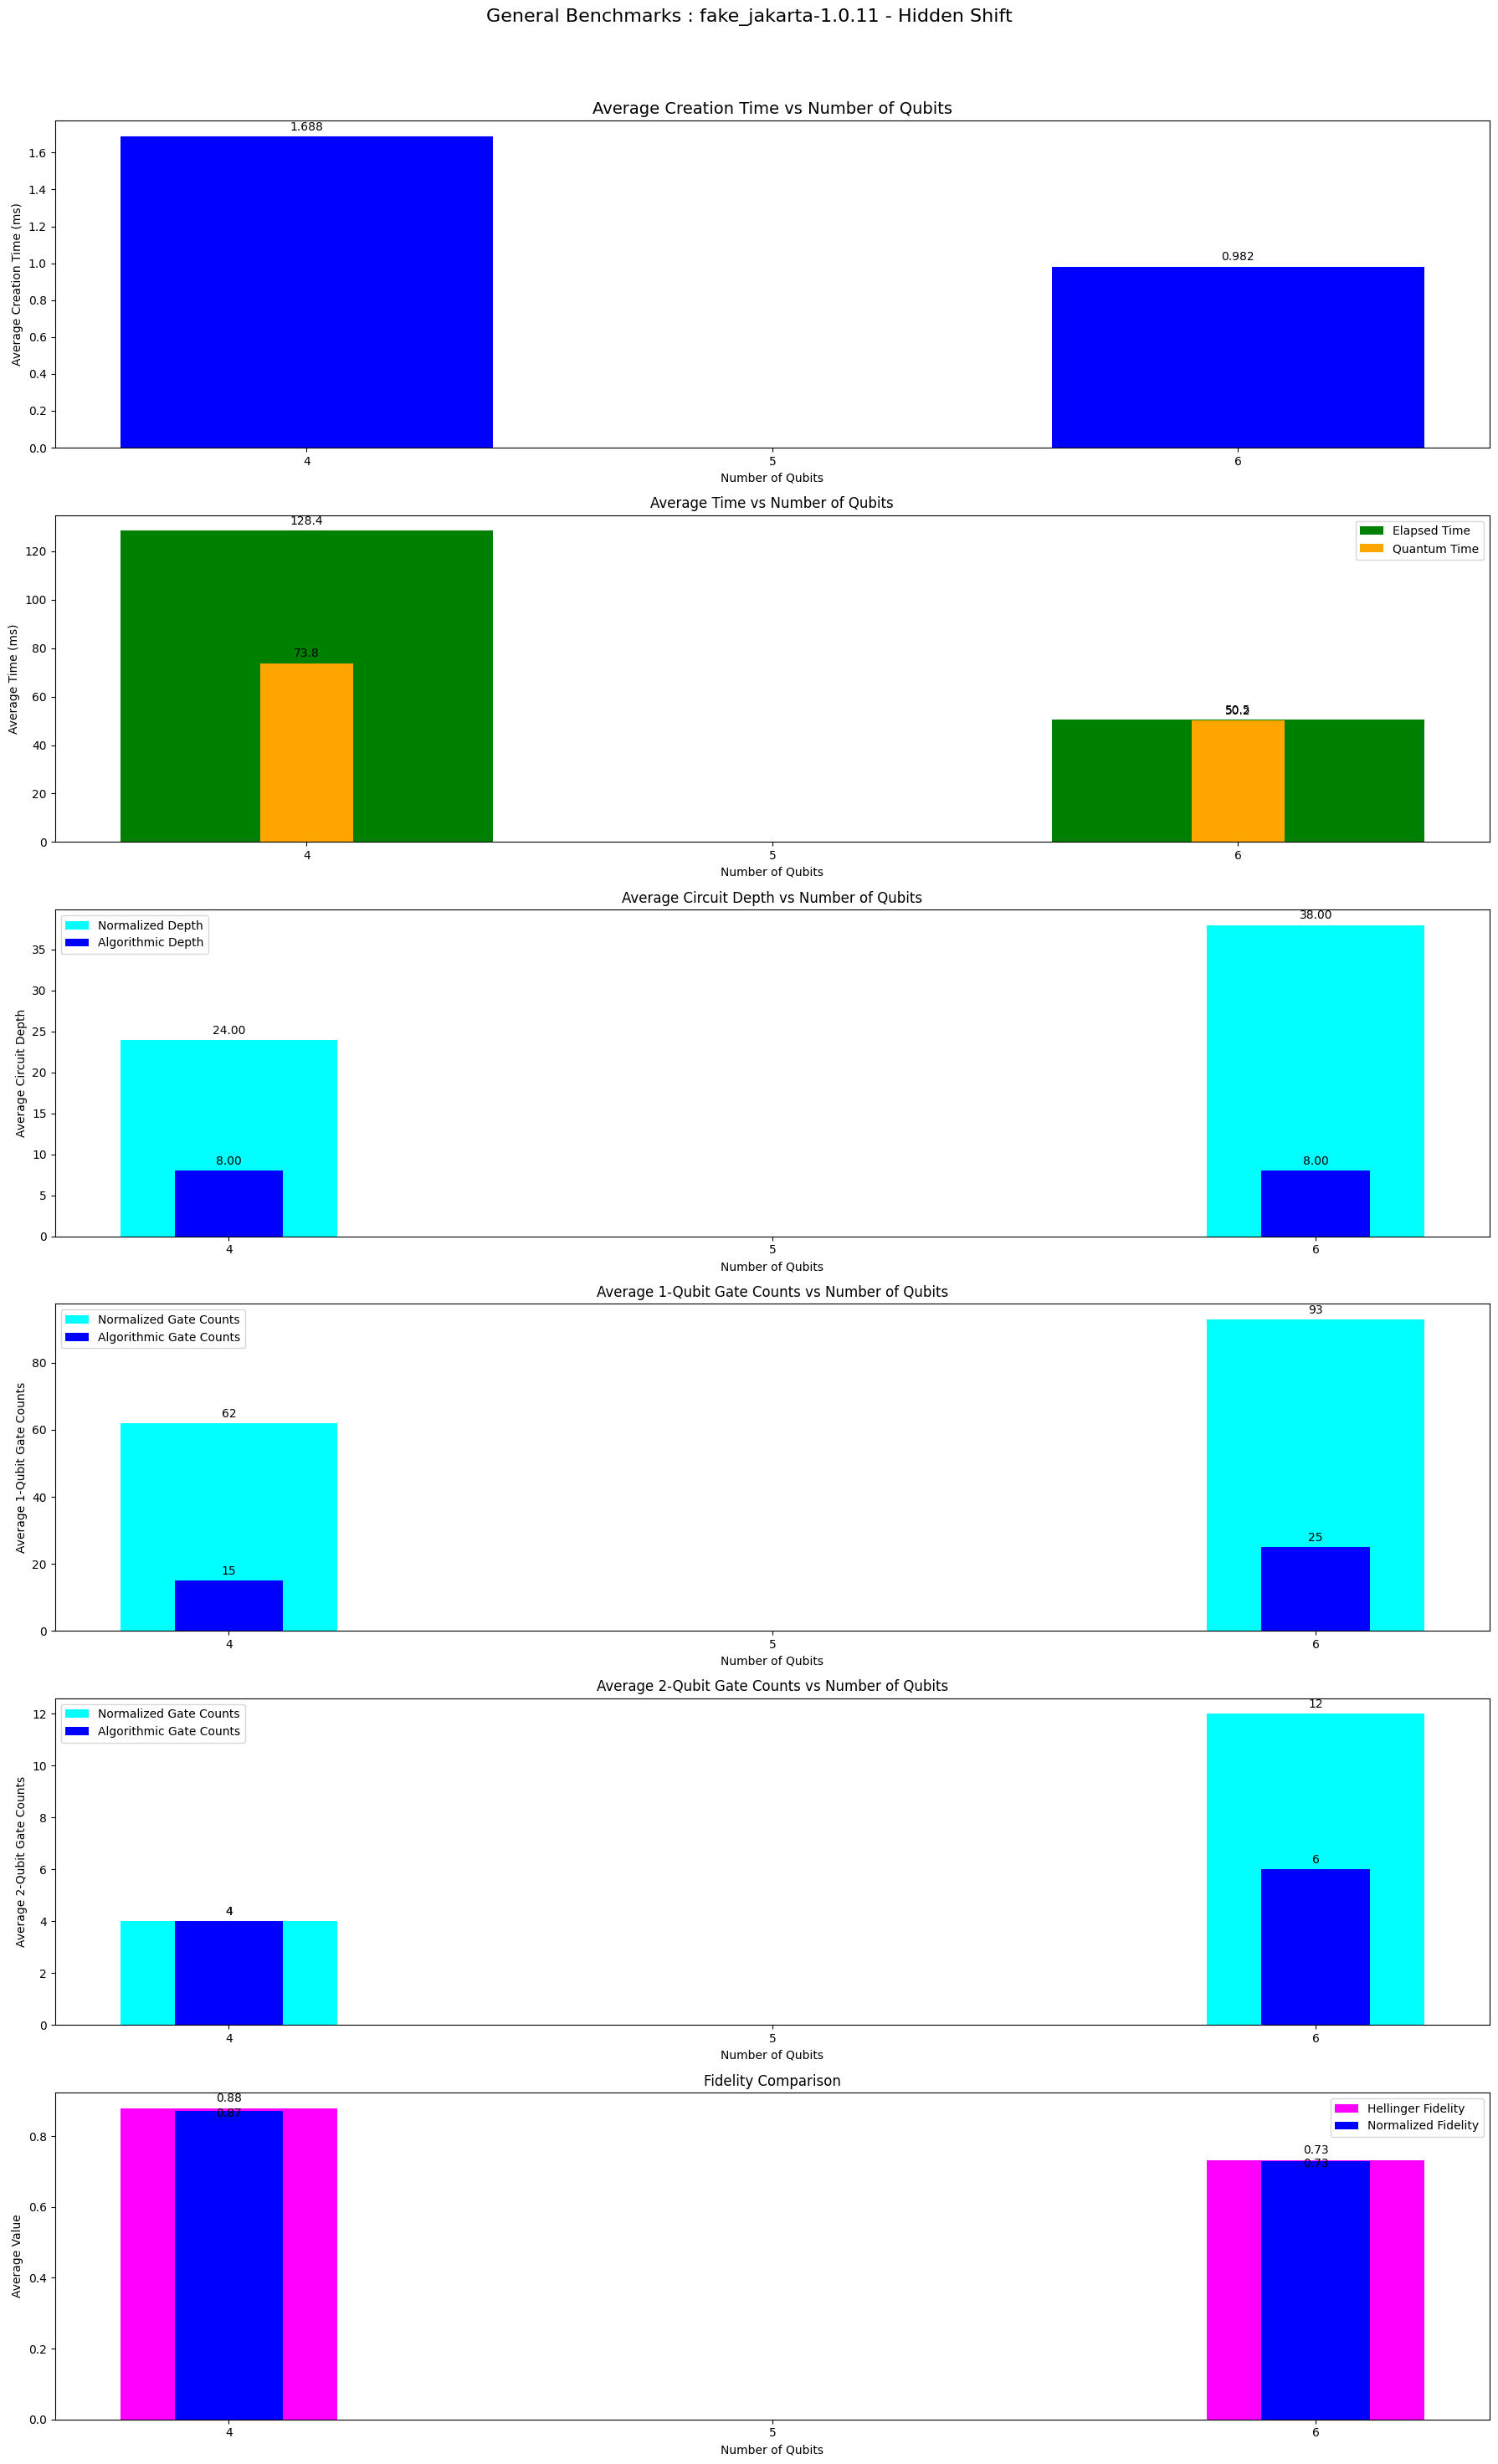

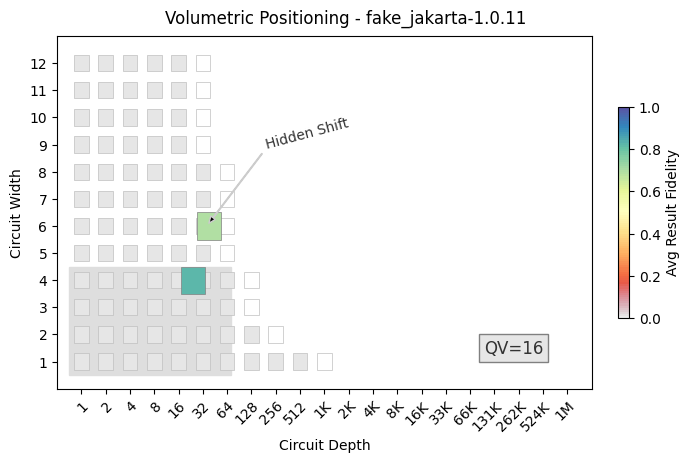

In [17]:
# Execute the benchmark program, accumulate metrics, and calculate circuit depths
(creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data, numckts,  
algorithmic_1Q_gate_counts, algorithmic_2Q_gate_counts, transpiled_1Q_gate_counts, transpiled_2Q_gate_counts) = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = []
avg_elapsed_times = []
avg_quantum_times = []
avg_circuit_depths = []
avg_transpiled_depths = []
avg_1Q_algorithmic_gate_counts = []
avg_2Q_algorithmic_gate_counts = []
avg_1Q_Transpiled_gate_counts = []
avg_2Q_Transpiled_gate_counts = []

start = 0
for num in numckts:
    avg_creation_times.append(np.mean(creation_times[start:start+num]))
    avg_elapsed_times.append(np.mean(elapsed_times[start:start+num]))
    avg_quantum_times.append(np.mean(quantum_times[start:start+num]))
    avg_circuit_depths.append(np.mean(circuit_depths[start:start+num]))
    avg_transpiled_depths.append(np.mean(transpiled_depths[start:start+num]))
    avg_1Q_algorithmic_gate_counts.append(int(np.mean(algorithmic_1Q_gate_counts[start:start+num])))
    avg_2Q_algorithmic_gate_counts.append(int(np.mean(algorithmic_2Q_gate_counts[start:start+num])))
    avg_1Q_Transpiled_gate_counts.append(int(np.mean(transpiled_1Q_gate_counts[start:start+num])))
    avg_2Q_Transpiled_gate_counts.append(int(np.mean(transpiled_2Q_gate_counts[start:start+num])))
    start += num

# Calculate the fidelity data
avg_f, avg_Hf = plot_fidelity_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")


# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits

# Add labels to the bars
def autolabel(rects,ax,str='{:.3f}',va='bottom'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str.format(height),  # Formatting to two decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va=va)

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(18, 30))
fig.suptitle(f"General Benchmarks : {platform} - {benchmark_name}", fontsize=16)
for i in range(len(avg_creation_times)): #converting seconds to milli seconds by multiplying 1000
    avg_creation_times[i] *= 1000

ax1.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
x = ax1.bar(num_qubits_range, avg_creation_times, color='blue')
autolabel(ax1.patches, ax1)
ax1.set_xlabel('Number of Qubits')
ax1.set_ylabel('Average Creation Time (ms)')
ax1.set_title('Average Creation Time vs Number of Qubits',fontsize=14)


ax2.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))

for i in range(len(avg_elapsed_times)): #converting seconds to milli seconds by multiplying 1000
    avg_elapsed_times[i] *= 1000

for i in range(len(avg_quantum_times)): #converting seconds to milli seconds by multiplying 1000
    avg_quantum_times[i] *= 1000

Elapsed= ax2.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
Quantum= ax2.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
autolabel(Elapsed,ax2,str='{:.1f}')
autolabel(Quantum,ax2,str='{:.1f}')
ax2.set_xlabel('Number of Qubits')
ax2.set_ylabel('Average Time (ms)')
ax2.set_title('Average Time vs Number of Qubits')
ax2.legend()


ax3.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
Normalized = ax3.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
Algorithmic = ax3.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
autolabel(Normalized,ax3,str='{:.2f}')
autolabel(Algorithmic,ax3,str='{:.2f}')
ax3.set_xlabel('Number of Qubits')
ax3.set_ylabel('Average Circuit Depth')
ax3.set_title('Average Circuit Depth vs Number of Qubits')
ax3.legend()

ax4.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
Normalized_1Q_counts = ax4.bar(num_qubits_range, avg_1Q_Transpiled_gate_counts, color='cyan', label='Normalized Gate Counts', width=0.4)  # Adjust width here
Algorithmic_1Q_counts = ax4.bar(num_qubits_range, avg_1Q_algorithmic_gate_counts, color='blue', label='Algorithmic Gate Counts', width=0.2)  # Adjust width here
autolabel(Normalized_1Q_counts,ax4,str='{}')
autolabel(Algorithmic_1Q_counts,ax4,str='{}')
ax4.set_xlabel('Number of Qubits')
ax4.set_ylabel('Average 1-Qubit Gate Counts')
ax4.set_title('Average 1-Qubit Gate Counts vs Number of Qubits')
ax4.legend()

ax5.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
Normalized_2Q_counts = ax5.bar(num_qubits_range, avg_2Q_Transpiled_gate_counts, color='cyan', label='Normalized Gate Counts', width=0.4)  # Adjust width here
Algorithmic_2Q_counts = ax5.bar(num_qubits_range, avg_2Q_algorithmic_gate_counts, color='blue', label='Algorithmic Gate Counts', width=0.2)  # Adjust width here
autolabel(Normalized_2Q_counts,ax5,str='{}')
autolabel(Algorithmic_2Q_counts,ax5,str='{}')
ax5.set_xlabel('Number of Qubits')
ax5.set_ylabel('Average 2-Qubit Gate Counts')
ax5.set_title('Average 2-Qubit Gate Counts vs Number of Qubits')
ax5.legend()


ax6.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, 1))
Hellinger = ax6.bar(num_qubits_range, avg_Hf, width=0.4, label='Hellinger Fidelity',color="magenta")  # Adjust width here
Normalized = ax6.bar(num_qubits_range, avg_f, width=0.2, label='Normalized Fidelity', color="blue")  # Adjust width here
autolabel(Hellinger,ax6,str='{:.2f}')
autolabel(Normalized,ax6,str='{:.2f}',va="top")
ax6.set_xlabel('Number of Qubits')
ax6.set_ylabel('Average Value')
ax6.set_title("Fidelity Comparison")
ax6.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])
if saveplots == True:
    plt.savefig("ParameterPlotsSample.jpg")
plt.show()


# Quantum Volume Plot
Suptitle = f"Volumetric Positioning - {platform}"
appname=benchmark_name
if QV_ == None:
    QV=2048
else:
    QV=QV_
depth_base =2

ax = plot_volumetric_background(max_qubits=max_qbits, QV=QV,depth_base=depth_base, suptitle=Suptitle, colorbar_label="Avg Result Fidelity")

w_data = num_qubits_range
# determine width for circuit
w_max = 0
for i in range(len(w_data)):
    y = float(w_data[i])
    w_max = max(w_max, y)

d_tr_data = avg_transpiled_depths
f_data = avg_f

plot_volumetric_data(ax, w_data, d_tr_data, f_data, depth_base, fill=True,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, w_max=w_max)
anno_volumetric_data(ax, depth_base,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, fill=False)
